# Data exploration and experimentation

We need to explore data and try different optins for prediction models in order to decide what works better

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

%matplotlib inline

In [2]:
# Load train data for exploration
# The format is tab-separated values

df = pd.read_csv('./food_review/train.txt', sep='\t', names=['text', 'label'])
df.shape

(959, 2)

In [3]:
# Preview

df.head()

text  label
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1

In [4]:
# Let's now select a subset of the labeled dataset to work with.
# We need to preserve a validation dataset to have an ability to check
# all our insights in the end if necessary.

# In general this is a good practice, because after a lot of data
# experiments we can contaminate our approach with a methodological
# overfitting.

RANDOM_SEED = 12345

experiment = df.sample(frac=0.8, random_state=RANDOM_SEED)
validate = df.drop(experiment.index)

experiment = experiment.reset_index(drop=True)

experiment.shape

(767, 2)

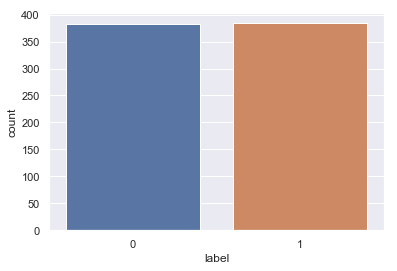

In [5]:
# Let's look at the class balance

ax = sns.countplot(x="label", data=experiment)

### Simplest approach first

First of all we can try API for sentiment analysis.
We use Google API (https://cloud.google.com/natural-language) here, but there are many other sentimeng API providers out there.

Quick search in google by one of the train and test example shows that we're working
with a subset of Yelp review dataset. So probably Google API is aware of these samples.

Anyway the first thing to try is to use some API if it's available and economically feasible

In [7]:
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

import os
from tqdm import tqdm

# Sample few documents - Google API is not very fast ~ 1 req/sec
# Not sure if it's possible to make batch request for this API

N = 200
google_test_dataset = experiment.sample(n=N, random_state=RANDOM_SEED).reset_index(drop=True)

# The credentials file is not in the repository !!!
# Ask me to provide it or create yourself here: https://cloud.google.com/natural-language/docs/quickstart
# You will need a google cloud account
#
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.expanduser('./MyJob-cred.json')

# Instantiates a client
client = language.LanguageServiceClient()

for i in tqdm(range(N)):
    document = types.Document(
        content=google_test_dataset.loc[i, 'text'],
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects the sentiment of the text
    sentiment = client.analyze_sentiment(document=document).document_sentiment
    google_test_dataset.loc[i, 'google_sentiment_score'] = sentiment.score
    google_test_dataset.loc[i, 'google_sentiment_magnitude'] = sentiment.magnitude

100%|██████████| 200/200 [01:04<00:00,  3.62it/s]


In [8]:
# Let's check the accuracy of Google API

from sklearn.metrics import accuracy_score

Y_api_prediction = google_test_dataset.google_sentiment_score > 0
Y = google_test_dataset.label

accuracy_score(Y, Y_api_prediction)

0.95

As we can see with 200 examples (it's quite enough here) the accuracy is 95%. Chances are that Google model was trained with our samples. The speed is ~ 3 samples / sec, so for some applications it can be acceptable. 

### Try some machine learning
We don't have much data, that's why we're not going to use sophisticated approaches with RNN or CNN.
As one can see in this review: https://blog.paralleldots.com/data-science/breakthrough-research-papers-and-models-for-sentiment-analysis, simple methods like Naive Bayes and SVM work rather good with small number of examples and short snippets of texts.

We'll represent our texts as bag of words.

Now we will evaluate few models with default paremeters.

There is no specific additional information in the task about consequent usage of the classification results. It would be better to find this out, but for now we can use **accuracy** as a model quality metric, because it's quite easy to comprehend even for nonprofessional.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

FOLDS = 5
N_JOBS = 5

In [10]:
# Grid search for best TFIDF transform parameters

corpus = experiment.text
Y = experiment.label

docs_N_in_cv = (FOLDS - 1) / FOLDS * len(corpus)

param_grid = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': np.array(range(3, 20, 2)) / docs_N_in_cv, # From 3 to 20 min documents per term
    'tfidf__binary': [True, False],
    'tfidf__use_idf': [True, False]
}

def search_wrapper(pipeline, param_grid=param_grid, X=corpus, Y=Y):
    search = GridSearchCV(pipeline, param_grid, iid=False, 
                          scoring='accuracy', cv=FOLDS, return_train_score=False)
    res = search.fit(X, Y)
    
    print('Best params:', res.best_params_)
    scores_lst = [res.cv_results_['split{}_test_score'.format(i)][res.best_index_] 
                       for i in range(FOLDS)]
    scores = np.array(scores_lst)
    print('CV score:', scores)
    print('CV mean score:', scores.mean())
    return(scores)

### Bag of words based approach

We use tfidf transform and four different learners

In [11]:
res = dict()

In [12]:
# Logistic regression first as it's one of the simplest models

from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), analyzer='word')),
    ('lr', LogisticRegression(solver='liblinear', penalty='l1'))
])

print('Logistic Regression model \n')
%time res['lr'] = search_wrapper(pipeline)

Logistic Regression model 

Best params: {'tfidf__binary': False, 'tfidf__min_df': 0.008148631029986962, 'tfidf__stop_words': None, 'tfidf__use_idf': True}
CV score: [0.72727273 0.72727273 0.81168831 0.81045752 0.70394737]
CV mean score: 0.7561277301989378
CPU times: user 10.9 s, sys: 42.5 ms, total: 11 s
Wall time: 11.2 s


In [13]:
# Naive Bayes
# MultinomialNB is recommended to use with counts in theory, but in practice tfidf works too

from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), analyzer='word')),
    ('nb', MultinomialNB())
])

print('Naive Bayes model \n')
%time res['nb'] = search_wrapper(pipeline)

Naive Bayes model 

Best params: {'tfidf__binary': False, 'tfidf__min_df': 0.0048891786179921775, 'tfidf__stop_words': None, 'tfidf__use_idf': False}
CV score: [0.68181818 0.74675325 0.81168831 0.79738562 0.76315789]
CV mean score: 0.760160651182323
CPU times: user 11.4 s, sys: 50.9 ms, total: 11.4 s
Wall time: 11.8 s


In [14]:
# GradientBoosting

from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), analyzer='word')),
    ('gb', GradientBoostingClassifier())
])

print('GradientBoosting model \n')
%time res['gb'] = search_wrapper(pipeline)

GradientBoosting model 

Best params: {'tfidf__binary': False, 'tfidf__min_df': 0.008148631029986962, 'tfidf__stop_words': None, 'tfidf__use_idf': False}
CV score: [0.74025974 0.72727273 0.81818182 0.81045752 0.72368421]
CV mean score: 0.7639712025160943
CPU times: user 44.2 s, sys: 152 ms, total: 44.3 s
Wall time: 45.4 s


In [15]:
# Support Vector Machines

from sklearn.svm import NuSVC

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), analyzer='word')),
    ('svm', NuSVC(gamma='scale'))
])

print('Support Vector Machines \n')
%time res['svm'] = search_wrapper(pipeline)

Support Vector Machines 

Best params: {'tfidf__binary': True, 'tfidf__min_df': 0.0048891786179921775, 'tfidf__stop_words': None, 'tfidf__use_idf': True}
CV score: [0.73376623 0.76623377 0.78571429 0.78431373 0.75657895]
CV mean score: 0.7653213917145806
CPU times: user 18.1 s, sys: 57 ms, total: 18.2 s
Wall time: 18.5 s


### Shingles based approach

SVM performs rather well as it was promissed in the review.

We can now try to check another tokenization option - use char n-grams ("shingles"), instead of word or work n-grams. 
To save time we'll "borrow" some other tfidf parameters from word-based SVM

In [16]:
char_param_grid = {
    'tfidf__min_df': [0.0048891786179921775],
    'tfidf__binary': [True],
    'tfidf__use_idf': [True],
    'tfidf__ngram_range': [(3, 4), (3, 5), (3, 6)], # shingles shorter than 3 chars seem too short
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char')),
    ('svm', NuSVC(gamma='scale'))
])

print('Support Vector Machines & shingles \n')
%time res['svm_sh'] = search_wrapper(pipeline, param_grid=char_param_grid)

Support Vector Machines & shingles 

Best params: {'tfidf__binary': True, 'tfidf__min_df': 0.0048891786179921775, 'tfidf__ngram_range': (3, 5), 'tfidf__use_idf': True}
CV score: [0.75974026 0.83116883 0.84415584 0.84313725 0.81578947]
CV mean score: 0.8187983327302213
CPU times: user 7.55 s, sys: 73.9 ms, total: 7.62 s
Wall time: 7.81 s


The accuracy with char n-gramms looks better than with previous approaches.

### Ways to improve

We could also try to ensemble models of different kind. For example SVM with shingles and tree gradient boosting with words.

The other way would be to use some additional information. Our dataset is quite small, so we can try to use pretrained word embeddings to improve sentence representation. In this case we can just sum embeddings from each word of the sentence.

We will use FastText (https://fasttext.cc) by Facebook with pretrained models for English language (https://fasttext.cc/docs/en/crawl-vectors.html).

FastText has command line utilites to compute word and sentence representations. For that particular model the length of vectors is 300.

In [17]:
# Installing FastText

! git clone https://github.com/facebookresearch/fastText.git
! cd fastText; make

Cloning into 'fastText'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 3120 (delta 3), reused 8 (delta 1), pack-reused 3101
Receiving objects: 100% (3120/3120), 7.82 MiB | 2.20 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/loss.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/densematrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/quantmatrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-l

In [18]:
# FastText pretrained model should be downloaded. Its size is 7.2Gb.
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

In [19]:
! ls -al cc.en.300.bin

-rw-r--r--@ 1 alexey  staff  7237176312 Mar 28 12:29 cc.en.300.bin


In [20]:
# We save our samples without labels
experiment.text.to_csv('experiment.txt', header=False, index=False)

In [21]:
# Make an embedding for every experiment sample
#

%time ! ./fastText/fasttext print-sentence-vectors cc.en.300.bin < experiment.txt > experiment.vec

CPU times: user 466 ms, sys: 113 ms, total: 579 ms
Wall time: 32.9 s


In [22]:
vec = pd.read_csv('experiment.vec', sep=' ', names=range(301)) # There is last empty column
vec = vec.drop(labels=300, axis='columns')

In [23]:
model = NuSVC(gamma='scale')

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'nu': [0.5, 0.475, 0.45]
}

print('FastText embedding & Support Vector Machines \n')
%time res['ft_svm'] = search_wrapper(model, param_grid=param_grid, X=vec.values, Y=Y)

FastText embedding & Support Vector Machines 

Best params: {'kernel': 'linear', 'nu': 0.475}
CV score: [0.81818182 0.79220779 0.88311688 0.8627451  0.80263158]
CV mean score: 0.8317766340986156
CPU times: user 7.69 s, sys: 61.5 ms, total: 7.75 s
Wall time: 7.98 s


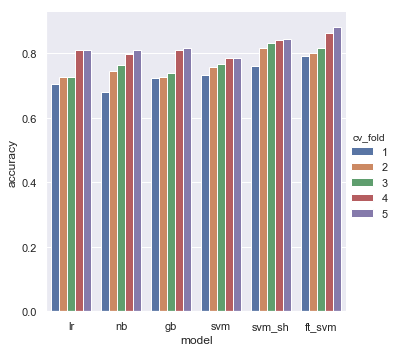

In [24]:
model_results = pd.DataFrame(columns=['model', 'cv_fold', 'accuracy'])

for name in ['lr', 'nb', 'gb', 'svm', 'svm_sh', 'ft_svm']:
    rdf = pd.DataFrame({'model': [name] * FOLDS, 'cv_fold': range(1, FOLDS + 1), 'accuracy': np.sort(res[name])})
    model_results = model_results.append(rdf)
model_results = model_results.reset_index(drop=True)

sns.catplot(x='model', y='accuracy', hue='cv_fold', data=model_results, kind='bar')

### Final discussion of models

We've managed to get results even better than with shingles; but the accuracy improvement is not very significant with our number of samples. Nevertheless this method is better than any of our word-based methods with tfidf. So the best quality can be probably expected when we ensemble shingle and embedding based approaches.

On the other hand, embeding based method isn't performant, or we need to keep the model in RAM. The problem is that embedding model size is 7.2Gb, so it takes more than 30 sec to load on MacBook Pro.

So the production approach could be implemented either with API or with SVM model and shingles.

To be more independent we're going to pick the second option.

### Measure for sentiment
Some models and APIs provide sentiment magniture. Without API or additional labels we can't make a model with sentiment magnitudes because magnitude of sentiment should correspont to the strength of the sentiment. I.e. we need to tell apart for example "The food was good" and "It's NOT just food it was the greatest experience in my life!!!", to do so we need either additional data in traing dataset or knowledge about language in general.

So as a measure we will use probability output of the model, i.e. how sure model is about sentiment polarity.

In [25]:
# Now let's explore sentiment measure
# We'll use probability

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold

K = 20
X = df.text
Y = df.label

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', 
        min_df=0.005, binary=True, use_idf=True, ngram_range=(3, 5))),
    ('svm', NuSVC(gamma='scale', probability=True))
    #('lr', LogisticRegression())
    #('gb', GradientBoostingClassifier())
])

kf = KFold(n_splits=K)

# Predictions container
Y_prediction = pd.Series(index=Y.index)

In [26]:
%%time 

#
# Now we make K-fold split and train the model with every train part in split
# then predict unseen (test) part of data and "cover" all experimentation
# dataset. So as a result we get probability predictions for every sample
# without overfitting.
#

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model = pipeline.fit(X_train, Y_train)
    Y_prediction.loc[test_index] = model.predict_proba(X_test)[:, 1] # 1 for positive

CPU times: user 1min, sys: 217 ms, total: 1min
Wall time: 1min 1s


In [27]:
#
# Probability density function estimation for sentiment being positive
# Green - for samples marked as positive in train dataset
# Red - for samples marked as negative in train dataset
#

ax = sns.kdeplot(Y_prediction[Y == 1], shade=True, color="g", clip=(0, 1), label="positive")
ax = sns.kdeplot(Y_prediction[Y == 0], shade=True, color="r", clip=(0, 1), label="negative")
_ = ax.set_title('PDF of being classified as positive by the model, X - probability estimation of the model')

To make it more "intuitive" we can map probability to (-1, 1) interval. Negative values correspond to negative sentiment, positives - to positive.

In [28]:
Y_rescaled = 2 * Y_prediction - 1

In [29]:
ax = sns.kdeplot(Y_rescaled[Y == 1], shade=True, color="g", clip=(-1, 1), label="positive")
ax = sns.kdeplot(Y_rescaled[Y == 0], shade=True, color="r", clip=(-1, 1), label="negative")
_ = ax.set_title('PDF of being classified as positive by the model, X - sentiment measure')